In [12]:
import cv2
import numpy as np
import dlib
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# Initialize dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

(-0.5, 196.5, 254.5, -0.5)

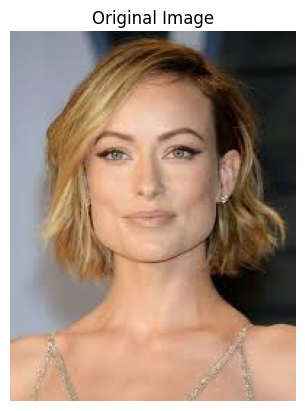

In [32]:
# Load the image
image_path = './test/test7.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

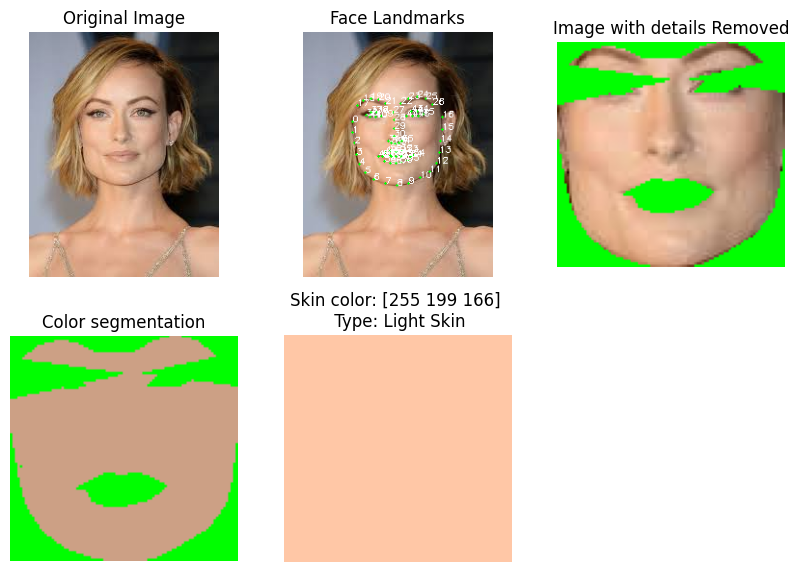

In [36]:
# Step 1: Identify face landmarks using dlib
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = detector(gray)

fig, ax = plt.subplots(2, 3, figsize=(10, 7))
for row in ax:
    for col in row:
        col.axis('off')
if len(faces) > 0:
    face = faces[0]
    landmarks = predictor(gray, face)
    
    face_points = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)]
    # Plot the original image
    ax[0, 0].imshow(image_rgb)
    ax[0, 0].set_title("Original Image")
    
    # Draw landmarks on the image
    annotated_image = image_rgb.copy()
    annotated_image = image_rgb.copy()
    for i, point in enumerate(face_points):
        cv2.circle(annotated_image, point, 1, (0, 255, 0), -1)
        cv2.putText(annotated_image, str(i), (point[0], point[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)
    ax[0, 1].imshow(annotated_image)
    ax[0, 1].set_title("Face Landmarks")
    
    # Step 2: Remove the details
    lefteye_points = np.array(face_points[36:41], dtype=np.int32)
    righteye_points = np.array(face_points[42:47], dtype=np.int32)
    mouth_points = np.array(face_points[48:61], dtype=np.int32)
    cut_area = [lefteye_points, righteye_points, mouth_points]
    removed_eye_image = image_rgb.copy()

    for area in cut_area:
        mask = np.zeros(removed_eye_image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [area], 255)
        mask = cv2.bitwise_not(mask)
        removed_eye_image = cv2.bitwise_and(removed_eye_image, removed_eye_image, mask=mask)

    mask = np.zeros(removed_eye_image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(face_points[:27], dtype=np.int32)], 255)
    masked_image = cv2.bitwise_and(removed_eye_image, removed_eye_image, mask=mask)

    # Find the bounding box of the face
    y_values, x_values = np.where(mask == 255)
    x = min(x_values)
    y = min(y_values)
    w = max(x_values) - x
    h = max(y_values) - y
    # Crop the face from the image
    cropped_face = masked_image[y:y+h, x:x+w]
    green_color = np.array([0, 255, 0], dtype=np.uint8)

    black_pixels_mask = np.all(cropped_face == [0, 0, 0], axis=-1)

    green_image = np.full(cropped_face.shape, green_color, dtype=np.uint8)

    cropped_face = np.where(black_pixels_mask[..., None], green_image, cropped_face)

    ax[0, 2].imshow(cropped_face)
    ax[0, 2].set_title("Image with details Removed")

    # Step 3: Color segmentation and skin tone detection
    pixels = np.float32(cropped_face.reshape(-1, 3))
    n_colors = 2
    kmeans = KMeans(n_clusters=n_colors)
    labels = kmeans.fit_predict(pixels)

    colors = kmeans.cluster_centers_.astype(int)

    # Create a new image showing the dominant colors
    segmented_image = colors[labels].reshape(cropped_face.shape).astype(np.uint8)

    # Determine the dominant color, ignoring [0, 0, 0]
    dominant_colors = colors[np.unique(labels, return_counts=True)[1].argsort()[::-1]]
    dominant_color = next((color for color in dominant_colors if np.any(color != [0, 0, 0])), None)

    dominant_color_hsv = cv2.cvtColor(np.uint8([[dominant_color]]), cv2.COLOR_BGR2HSV)[0][0]
    factor = 1.3  # Adjust this value as needed
    dominant_color_hsv[2] = min(255, dominant_color_hsv[2] * factor)

    dominant_color = cv2.cvtColor(np.uint8([[dominant_color_hsv]]), cv2.COLOR_HSV2BGR)[0][0]

    # Determine the skin tone category based on the dominant color
    if dominant_color is not None and np.mean(dominant_color) > 127.5:
        skin_tone_category = "Light Skin"
    else:
        skin_tone_category = "Dark Skin"

    # Plot the result
    ax[1, 0].imshow(segmented_image)
    ax[1, 0].set_title(f"Color segmentation")

    # Plot the dominant color
    dominant_color_image = np.full((100, 100, 3), dominant_color, dtype=np.uint8)
    ax[1, 1].imshow(dominant_color_image)
    ax[1, 1].set_title(f"Skin color: {dominant_color} \n Type: {skin_tone_category}")
else:
    print("No face detected.")
    plt.show()
